In [1]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/frankaging/pyvene.git

In [2]:
import random
import pandas as pd
from tutorial_ioi_utils import *
from pyvene import embed_to_distrib, top_vals, format_token, sigmoid_boundary
from pyvene import (
    IntervenableModel,
    IntervenableRepresentationConfig,
    IntervenableConfig,
    LowRankRotatedSpaceIntervention,
    SkipIntervention,
    VanillaIntervention,
    BoundlessRotatedSpaceIntervention,
)
from pyvene import create_gpt2_lm

import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    scale_y_reverse,
    scale_fill_cmap,
    geom_text,
    scale_fill_gradient,
    geom_point,
    geom_line,
    theme_minimal,
    ylim,
    ggtitle,
    ggsave,
    labs,
    scale_x_discrete,
    geom_histogram,
    scale_fill_manual,
)

# please try not to do this, the plot somehow throw warnings though :(
import warnings

warnings.filterwarnings("ignore")

config, tokenizer, gpt2 = create_gpt2_lm(cache_dir="/Users/aryamanarora/.cache/huggingface/hub/")
# _ = gpt2.eval().to("cuda")

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 

loaded model


In [3]:
def path_patching_config(
    layer, stream="head_attention_value_output", unit="h.pos", num_layers=gpt2.config.n_layer
):
    intervening_component = [
        IntervenableRepresentationConfig(layer, stream, unit, group_key=0)
    ]
    restoring_components = []
    if not stream.startswith("mlp_"):
        restoring_components += [
            IntervenableRepresentationConfig(layer, "mlp_output", group_key=1)
        ]
    for i in range(layer+1, num_layers):
        restoring_components += [
            IntervenableRepresentationConfig(i, "attention_output", group_key=1),
            IntervenableRepresentationConfig(i, "mlp_output", group_key=1)
        ]
    intervenable_config = IntervenableConfig(
        intervenable_representations=intervening_component + restoring_components,
        intervenable_interventions_type=VanillaIntervention,
    )
    return intervenable_config, len(restoring_components)

In [4]:
test_distribution = PromptDistribution(
    names=NAMES[:20],
    objects=OBJECTS[len(OBJECTS) // 2 :],
    places=PLACES[len(PLACES) // 2 :],
    prefix_len=2,
    prefixes=PREFIXES,
    templates=TEMPLATES[2:],
)

D_test = test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=[
        "ABB",
    ],
    source_patterns=["DCE"],
    labels="name",
    samples_per_combination=50,
) + test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=[
        "BAB",
    ],
    source_patterns=["DCE"],
    labels="name",
    samples_per_combination=50,
)

In [5]:
for batch in D_test.batches(batch_size=1):
    print(batch.base, tokenizer.decode(batch.patched_answer_tokens[0][1]))
    print(batch.source, tokenizer.decode(batch.patched_answer_tokens[0][0]))
    break

[<===PROMPT=== Then, Xavier and Nicholas were working at the landfill. Nicholas decided to give a magazine to>]  Xavier
[<===PROMPT=== Then, Jack and William were working at the landfill. Carter decided to give a magazine to>]  None


In [6]:
pos = [_ for _ in range(18)]
data = []

for layer in range(8, 12):
    intervenable_config, num_restores = path_patching_config(layer)
    intervenable = IntervenableModel(intervenable_config, gpt2)

    for head in range(gpt2.config.n_head):
        eval_labels, eval_preds = [], []
        for batch_dataset in tqdm(D_test.batches(batch_size=4), total=25):
            # prepare
            base_inputs = batch_dataset.base.tokens
            source_inputs = batch_dataset.source.tokens
            labels = batch_dataset.patched_answer_tokens[:, 1].to(gpt2.device)

            # inference
            _, counterfactual_outputs = intervenable(
                {"input_ids": base_inputs["input_ids"]}, 
                sources=[{"input_ids": source_inputs["input_ids"]}, {"input_ids": base_inputs["input_ids"]}],
                unit_locations={
                    "sources->base": (
                        (
                            [[[[head]], [pos]]]+[[pos]]*num_restores, 
                            [[[[head]], [pos]]]+[[pos]]*num_restores
                        )
                    )
                }
            )
            eval_labels += [labels]
            eval_preds += [counterfactual_outputs.logits]
        
        # metrics
        eval_metrics = compute_metrics(
            eval_preds, eval_labels,
        )
        data.append({"layer": layer, "head": head, **eval_metrics})
        print(layer, head, eval_metrics)


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


8 0 {'accuracy': 0.82, 'kl_div': tensor(-77.8167), 'label_logit': -19.4541788482666, 'label_prob': 0.09454011559486389}


100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


8 1 {'accuracy': 0.83, 'kl_div': tensor(-77.8260), 'label_logit': -19.45649841308594, 'label_prob': 0.09464891910552979}


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


8 2 {'accuracy': 0.83, 'kl_div': tensor(-77.8241), 'label_logit': -19.456034317016602, 'label_prob': 0.09468493461608887}


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


8 3 {'accuracy': 0.82, 'kl_div': tensor(-77.8463), 'label_logit': -19.461565017700195, 'label_prob': 0.09374040558934212}


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


8 4 {'accuracy': 0.83, 'kl_div': tensor(-77.8223), 'label_logit': -19.455579681396486, 'label_prob': 0.09457402497529983}


100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


8 5 {'accuracy': 0.83, 'kl_div': tensor(-77.8409), 'label_logit': -19.46021240234375, 'label_prob': 0.09490960285067558}


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


8 6 {'accuracy': 0.83, 'kl_div': tensor(-77.8722), 'label_logit': -19.468041458129882, 'label_prob': 0.09558693200349808}


100%|██████████| 25/25 [00:15<00:00,  1.60it/s]


8 7 {'accuracy': 0.83, 'kl_div': tensor(-77.8296), 'label_logit': -19.457406005859376, 'label_prob': 0.09463822692632676}


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


8 8 {'accuracy': 0.83, 'kl_div': tensor(-77.8243), 'label_logit': -19.456082611083986, 'label_prob': 0.09446627259254456}


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


8 9 {'accuracy': 0.83, 'kl_div': tensor(-77.8234), 'label_logit': -19.455838928222658, 'label_prob': 0.0947052763402462}


100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


8 10 {'accuracy': 0.82, 'kl_div': tensor(-77.7829), 'label_logit': -19.44573532104492, 'label_prob': 0.09517998710274696}


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


8 11 {'accuracy': 0.83, 'kl_div': tensor(-77.8421), 'label_logit': -19.460517959594725, 'label_prob': 0.09397417336702346}


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


9 0 {'accuracy': 0.82, 'kl_div': tensor(-77.8602), 'label_logit': -19.465039749145507, 'label_prob': 0.09288053929805756}


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


9 1 {'accuracy': 0.83, 'kl_div': tensor(-77.8220), 'label_logit': -19.455493392944337, 'label_prob': 0.09464370399713516}


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


9 2 {'accuracy': 0.83, 'kl_div': tensor(-77.8549), 'label_logit': -19.463736114501952, 'label_prob': 0.0933874236047268}


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


9 3 {'accuracy': 0.83, 'kl_div': tensor(-77.8086), 'label_logit': -19.452139434814452, 'label_prob': 0.09454001277685166}


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


9 4 {'accuracy': 0.82, 'kl_div': tensor(-77.8366), 'label_logit': -19.459149017333985, 'label_prob': 0.09393242627382278}


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


9 5 {'accuracy': 0.83, 'kl_div': tensor(-77.8396), 'label_logit': -19.459906616210937, 'label_prob': 0.09522525012493134}


100%|██████████| 25/25 [00:08<00:00,  3.10it/s]


9 6 {'accuracy': 0.69, 'kl_div': tensor(-78.1733), 'label_logit': -19.543323822021485, 'label_prob': 0.08137807101011277}


100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


9 7 {'accuracy': 0.84, 'kl_div': tensor(-77.8093), 'label_logit': -19.452327880859375, 'label_prob': 0.09487992286682129}


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


9 8 {'accuracy': 0.8, 'kl_div': tensor(-77.9127), 'label_logit': -19.47817192077637, 'label_prob': 0.09072596490383149}


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


9 9 {'accuracy': 0.61, 'kl_div': tensor(-78.4247), 'label_logit': -19.606170043945312, 'label_prob': 0.07515710242092609}


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


9 10 {'accuracy': 0.83, 'kl_div': tensor(-77.8239), 'label_logit': -19.45597557067871, 'label_prob': 0.09461028382182121}


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


9 11 {'accuracy': 0.83, 'kl_div': tensor(-77.8411), 'label_logit': -19.46027656555176, 'label_prob': 0.09434530168771743}


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


10 0 {'accuracy': 0.72, 'kl_div': tensor(-78.2447), 'label_logit': -19.561167373657227, 'label_prob': 0.08155823305249214}


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


10 1 {'accuracy': 0.8, 'kl_div': tensor(-77.9222), 'label_logit': -19.480550079345704, 'label_prob': 0.09104949712753296}


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


10 2 {'accuracy': 0.78, 'kl_div': tensor(-77.9982), 'label_logit': -19.499538955688475, 'label_prob': 0.08611061483621597}


100%|██████████| 25/25 [00:08<00:00,  3.09it/s]


10 3 {'accuracy': 0.82, 'kl_div': tensor(-77.8963), 'label_logit': -19.474083557128907, 'label_prob': 0.09179006770253181}


100%|██████████| 25/25 [00:07<00:00,  3.15it/s]


10 4 {'accuracy': 0.83, 'kl_div': tensor(-77.9215), 'label_logit': -19.480383834838868, 'label_prob': 0.09488755151629448}


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


10 5 {'accuracy': 0.83, 'kl_div': tensor(-77.8219), 'label_logit': -19.455484085083008, 'label_prob': 0.09466711044311524}


100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


10 6 {'accuracy': 0.78, 'kl_div': tensor(-77.9595), 'label_logit': -19.489885787963868, 'label_prob': 0.08916458696126937}


100%|██████████| 25/25 [00:08<00:00,  3.12it/s]


10 7 {'accuracy': 0.84, 'kl_div': tensor(-77.3630), 'label_logit': -19.340760192871095, 'label_prob': 0.11077091604471206}


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


10 8 {'accuracy': 0.83, 'kl_div': tensor(-77.8239), 'label_logit': -19.455965881347655, 'label_prob': 0.0947995637357235}


100%|██████████| 25/25 [00:08<00:00,  3.09it/s]


10 9 {'accuracy': 0.82, 'kl_div': tensor(-77.8258), 'label_logit': -19.45645866394043, 'label_prob': 0.09423598289489746}


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


10 10 {'accuracy': 0.75, 'kl_div': tensor(-77.9774), 'label_logit': -19.49433738708496, 'label_prob': 0.08554709404706955}


100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


10 11 {'accuracy': 0.83, 'kl_div': tensor(-77.8350), 'label_logit': -19.458761444091795, 'label_prob': 0.09391723603010177}


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


11 0 {'accuracy': 0.82, 'kl_div': tensor(-77.7706), 'label_logit': -19.442651290893554, 'label_prob': 0.09458106890320778}


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


11 1 {'accuracy': 0.82, 'kl_div': tensor(-77.8636), 'label_logit': -19.465898056030273, 'label_prob': 0.09257157072424889}


100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


11 2 {'accuracy': 0.81, 'kl_div': tensor(-77.8520), 'label_logit': -19.462994689941407, 'label_prob': 0.09117126256227494}


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


11 3 {'accuracy': 0.81, 'kl_div': tensor(-77.9643), 'label_logit': -19.491077651977537, 'label_prob': 0.0899126648902893}


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


11 4 {'accuracy': 0.83, 'kl_div': tensor(-77.8637), 'label_logit': -19.465929107666014, 'label_prob': 0.0953715693950653}


100%|██████████| 25/25 [00:07<00:00,  3.15it/s]


11 5 {'accuracy': 0.83, 'kl_div': tensor(-77.8160), 'label_logit': -19.453999328613282, 'label_prob': 0.0945980504155159}


100%|██████████| 25/25 [00:08<00:00,  3.10it/s]


11 6 {'accuracy': 0.8, 'kl_div': tensor(-77.8933), 'label_logit': -19.4733260345459, 'label_prob': 0.09145819887518883}


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


11 7 {'accuracy': 0.83, 'kl_div': tensor(-77.8228), 'label_logit': -19.455703735351562, 'label_prob': 0.09471094027161599}


100%|██████████| 25/25 [00:08<00:00,  3.12it/s]


11 8 {'accuracy': 0.83, 'kl_div': tensor(-78.0200), 'label_logit': -19.504987030029298, 'label_prob': 0.09413659200072289}


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


11 9 {'accuracy': 0.83, 'kl_div': tensor(-77.8874), 'label_logit': -19.47185272216797, 'label_prob': 0.09214330732822418}


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


11 10 {'accuracy': 0.87, 'kl_div': tensor(-77.4900), 'label_logit': -19.372491302490236, 'label_prob': 0.1088036684691906}


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]

11 11 {'accuracy': 0.83, 'kl_div': tensor(-78.4939), 'label_logit': -19.623487701416014, 'label_prob': 0.09251372799277306}


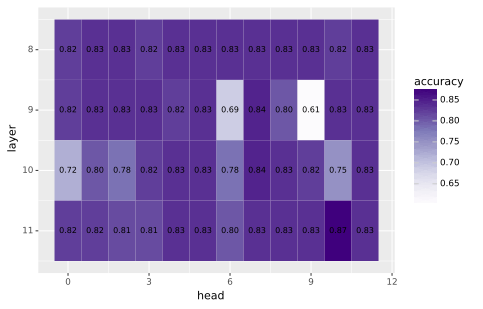

In [23]:
df = pd.DataFrame(data)
df["accuracy_formatted"] = df["accuracy"].apply(lambda x: f"{x:.2f}")
plot = (
    ggplot(df, aes(x="head", y="layer", fill="accuracy")) + geom_tile()
    + scale_fill_cmap(colors["block_output"]) + scale_y_reverse()
    + geom_text(aes(label="accuracy_formatted"), size=8, color="black")
)
print(plot)

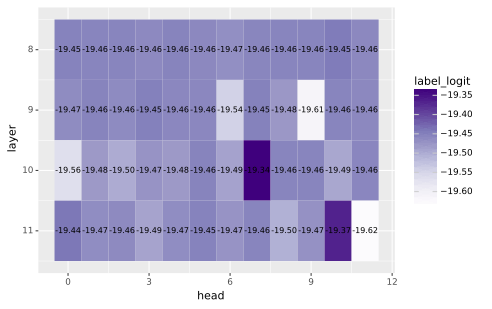

In [13]:
df = pd.DataFrame(data)
df["label_logit_formatted"] = df["label_logit"].apply(lambda x: f"{x:.2f}")
plot = (
    ggplot(df, aes(x="head", y="layer", fill="label_logit")) + geom_tile()
    + scale_fill_cmap(colors["block_output"]) + scale_y_reverse()
    + geom_text(aes(label="label_logit_formatted"), size=8, color="black")
)
print(plot)